In [1]:
import pyspark.sql.functions as fn

In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load from Parquet

In [4]:
df = spark.read.parquet('../dataset/M20_cards.parquet')

In [5]:
df.createOrReplaceTempView("cards")

In [6]:
df.columns

['number',
 'rarity',
 'name',
 'convertedManaCost',
 'numColors',
 'colorIdentity',
 'encodedColorIdentity',
 'types',
 'encodedTypes',
 'subTypes',
 'encodedSubTypes',
 'superTypes',
 'encodedSuperTypes',
 'originalText',
 'filteredText',
 'power',
 'toughness']

# Descriptive Statistics 

## Types

In [7]:
df.select("types").distinct().show()

+-----------------+
|            types|
+-----------------+
|             Land|
|          Sorcery|
|          Instant|
|      Enchantment|
|         Artifact|
|Artifact,Creature|
|     Planeswalker|
|         Creature|
+-----------------+



In [8]:
card_sum = df.groupBy("types").count().agg(
    fn.sum("count")
).alias('sum')

In [9]:
card_sum.show()

+----------+
|sum(count)|
+----------+
|       329|
+----------+



In [10]:
card_sum = int(card_sum.toPandas().loc[0])

In [11]:
bcast = sc.broadcast(card_sum)

In [12]:
bcast.value

329

In [13]:
df.groupBy("types").count().show()

+-----------------+-----+
|            types|count|
+-----------------+-----+
|             Land|   24|
|          Sorcery|   27|
|          Instant|   37|
|      Enchantment|   21|
|         Artifact|   17|
|Artifact,Creature|   10|
|     Planeswalker|   12|
|         Creature|  181|
+-----------------+-----+



In [14]:
@fn.udf
def udf_count_to_perc(count):
    print(count, bcast.value)
    return count / bcast.value

In [15]:
df.groupBy("types").count().withColumn('perc', udf_count_to_perc('count')).show()

+-----------------+-----+--------------------+
|            types|count|                perc|
+-----------------+-----+--------------------+
|             Land|   24|  0.0729483282674772|
|          Sorcery|   27| 0.08206686930091185|
|          Instant|   37| 0.11246200607902736|
|      Enchantment|   21| 0.06382978723404255|
|         Artifact|   17| 0.05167173252279635|
|Artifact,Creature|   10|0.030395136778115502|
|     Planeswalker|   12|  0.0364741641337386|
|         Creature|  181|  0.5501519756838906|
+-----------------+-----+--------------------+



In [16]:
df.groupBy("encodedTypes").count().show()

+------------+-----+
|encodedTypes|count|
+------------+-----+
|           1|   10|
|           6|   12|
|           3|   21|
|           5|   24|
|           4|   37|
|           7|   27|
|           2|  181|
|           0|   17|
+------------+-----+



## Power & Toughness

In [17]:
df.agg({"toughness": "min", "toughness": "max", "toughness": "mean"}).collect()

[Row(avg(toughness)=2.93717277486911)]

In [18]:
df.agg(
    *[fn.min("power"),  fn.max("power"), fn.mean("power")]
).show()

+----------+----------+------------------+
|min(power)|max(power)|        avg(power)|
+----------+----------+------------------+
|         0|         8|2.7421052631578946|
+----------+----------+------------------+



In [19]:
df.agg(
    *[fn.min("toughness"),  fn.max("toughness"), fn.mean("toughness")]
).show()

+--------------+--------------+----------------+
|min(toughness)|max(toughness)|  avg(toughness)|
+--------------+--------------+----------------+
|             0|             8|2.93717277486911|
+--------------+--------------+----------------+



## Length of name 

In [20]:
df.selectExpr("name").select('name', fn.length("name")).show()

+--------------------+------------+
|                name|length(name)|
+--------------------+------------+
|Chandra, Awakened...|          25|
|   Cavalier of Flame|          17|
|  Cavalier of Thorns|          18|
|Omnath, Locus of ...|          25|
|Kaalia, Zenith Se...|          21|
|       Coral Merfolk|          13|
|  Mask of Immolation|          18|
|    Cavalier of Dawn|          16|
|  Wolfrider's Saddle|          18|
|          Risen Reef|          10|
| Atemsis, All-Seeing|          19|
|Overgrowth Elemental|          20|
|      Barkhide Troll|          14|
|     Voracious Hydra|          15|
|   Gruesome Scourger|          17|
|    Icon of Ancestry|          16|
|       Cryptic Caves|          13|
|      Evolving Wilds|          14|
|       Fortress Crab|          13|
|Mu Yanling, Sky D...|          22|
+--------------------+------------+
only showing top 20 rows



In [21]:
df.selectExpr("name").\
    select("name", fn.split("name", "\s+").alias("tokens")).\
    select("name", "tokens", fn.size("tokens").alias("num_tokens")).\
    show()

+--------------------+--------------------+----------+
|                name|              tokens|num_tokens|
+--------------------+--------------------+----------+
|Chandra, Awakened...|[Chandra,, Awaken...|         3|
|   Cavalier of Flame|[Cavalier, of, Fl...|         3|
|  Cavalier of Thorns|[Cavalier, of, Th...|         3|
|Omnath, Locus of ...|[Omnath,, Locus, ...|         5|
|Kaalia, Zenith Se...|[Kaalia,, Zenith,...|         3|
|       Coral Merfolk|    [Coral, Merfolk]|         2|
|  Mask of Immolation|[Mask, of, Immola...|         3|
|    Cavalier of Dawn|[Cavalier, of, Dawn]|         3|
|  Wolfrider's Saddle|[Wolfrider's, Sad...|         2|
|          Risen Reef|       [Risen, Reef]|         2|
| Atemsis, All-Seeing|[Atemsis,, All-Se...|         2|
|Overgrowth Elemental|[Overgrowth, Elem...|         2|
|      Barkhide Troll|   [Barkhide, Troll]|         2|
|     Voracious Hydra|  [Voracious, Hydra]|         2|
|   Gruesome Scourger|[Gruesome, Scourger]|         2|
|    Icon 

## Length of text 

In [22]:
df.selectExpr("name", "originalText").\
    select("name", fn.length("originalText").alias("len_text")).\
    orderBy(fn.desc("len_text")).\
    show()

+--------------------+--------+
|                name|len_text|
+--------------------+--------+
|Ajani, Strength o...|     419|
|Chandra, Awakened...|     376|
|Chandra, Acolyte ...|     367|
|Sorin, Imperious ...|     332|
|   Cavalier of Flame|     331|
|    Icon of Ancestry|     329|
|Vivien, Arkbow Ra...|     314|
|  Cavalier of Thorns|     310|
|Vivien, Nature's ...|     305|
|      Veil of Summer|     303|
|Omnath, Locus of ...|     292|
|  Mask of Immolation|     291|
|        Gods Willing|     291|
|Golos, Tireless P...|     291|
|  Wolfrider's Saddle|     283|
|Kaalia, Zenith Se...|     283|
|   Cavalier of Night|     282|
|   Goblin Ringleader|     281|
|      Tomebound Lich|     281|
|    Cavalier of Dawn|     274|
+--------------------+--------+
only showing top 20 rows



## Mana costs 

In [23]:
df.select("name", fn.col("convertedManaCost").alias("cmc")).orderBy(fn.desc("cmc")).show()

+--------------------+---+
|                name|cmc|
+--------------------+---+
|Vilis, Broker of ...|  8|
|        Meteor Golem|  7|
| Scholar of the Ages|  7|
|         Dragon Mage|  7|
|Drakuseth, Maw of...|  7|
|  Agent of Treachery|  7|
|Sephara, Sky's Blade|  7|
|       Howling Giant|  7|
|Chandra, Awakened...|  6|
|Gargos, Vicious W...|  6|
|Chandra, Flame's ...|  6|
|      Flood of Tears|  6|
|Ajani, Inspiring ...|  6|
|   Bloodsoaked Altar|  6|
|    Captivating Gyre|  6|
| Sorin, Vampire Lord|  6|
|Vivien, Nature's ...|  6|
|  Aggressive Mammoth|  6|
|    Angelic Guardian|  6|
|  Wakeroot Elemental|  6|
+--------------------+---+
only showing top 20 rows



# Groups 

## By color identity

In [24]:
df.groupby('colorIdentity').count().show()

+-------------+-----+
|colorIdentity|count|
+-------------+-----+
|          G,W|    2|
|        G,R,U|    1|
|        B,G,U|    1|
|        B,G,W|    1|
|    B,G,R,U,W|    1|
|            B|   55|
|          R,W|    3|
|        G,R,W|    1|
|          G,R|    2|
|            U|   50|
|          B,W|    3|
|          B,R|    2|
|          G,U|    3|
|            W|   59|
|            R|   55|
|          B,U|    2|
|            G|   54|
|        R,U,W|    1|
|          U,W|    2|
|        B,R,W|    1|
+-------------+-----+
only showing top 20 rows



In [25]:
df.groupby('colorIdentity').count().agg(
    fn.sum("count")
).show()

+----------+
|sum(count)|
+----------+
|       329|
+----------+



## From Models, show encoded types

In [26]:
from pyspark.ml.feature import StringIndexer, StringIndexerModel

In [27]:
indexer = StringIndexer.load("../models/pyspark/stringindexer_str_types")
model = StringIndexerModel.load("../models/pyspark/stringindexer_model_str_types")

In [28]:
# model.stringOrderType

In [29]:
model.labels

['Artifact',
 'Artifact,Creature',
 'Creature',
 'Enchantment',
 'Instant',
 'Land',
 'Planeswalker',
 'Sorcery']

In [30]:
df.agg(fn.min(df.encodedTypes),fn.max(df.encodedTypes)).show()

+-----------------+-----------------+
|min(encodedTypes)|max(encodedTypes)|
+-----------------+-----------------+
|                0|                7|
+-----------------+-----------------+



## Make an overall histogram from encoded types. 

In [31]:
tmp = df.select("encodedTypes").rdd.flatMap(lambda x: x)

In [32]:
tmp.min()

0

In [33]:
tmp.max()

7

In [34]:
hist = df.select("encodedTypes").rdd.flatMap(lambda x: x).histogram(8)

In [35]:
hist

([0.0, 0.875, 1.75, 2.625, 3.5, 4.375, 5.25, 6.125, 7],
 [17, 10, 181, 21, 37, 24, 12, 27])

In [36]:
pd_hist = pd.DataFrame(data=list(zip(*hist)), columns=['bin', 'freq'])

In [37]:
pd_hist['perc'] = pd_hist['freq'] / pd_hist['freq'].sum()

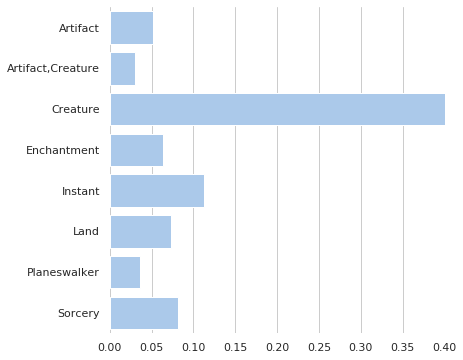

In [38]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 6))

sns.set_color_codes("pastel")
sns.barplot(x="perc", y="bin", data=pd_hist, label="Total", orient='h', color="b")

ax.set(xlim=(0, 0.4), xlabel="", ylabel="")
# ax.set(xlim=(0, 0.5), xlabel="%", ylabel="Creature type")
ax.set(yticklabels=model.labels)

sns.despine(left=True, bottom=True)

## By color identity and encoded type

First, let's fetch the distinct color identities

In [39]:
pd_colorIdentities  = df.select("colorIdentity").alias("Color_Identity").distinct().sort("colorIdentity").toPandas()

In [40]:
pd_colorIdentities

,colorIdentity
0,
1,B
2,"B,G"
3,"B,G,R,U,W"
4,"B,G,U"
5,"B,G,W"
6,"B,R"
7,"B,R,W"
8,"B,U"
9,"B,W"


In [41]:
pd_encodedTypes = pd.DataFrame(np.arange(8), columns=['Encoded_Types'])

In [42]:
pd_encodedTypes

,Encoded_Types
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7


Create a cartesian product of the color identities and the encoded types.

In [43]:
pd_colorIdentities['key'] = 0
pd_encodedTypes['key'] = 0

In [44]:
pd_cartesian = pd_colorIdentities.merge(pd_encodedTypes, how='outer').drop(columns=['key'])

In [45]:
pd_cartesian = pd_cartesian.rename(columns={'colorIdentity':'Color_Identity'})

In [46]:
pd_cartesian

,Color_Identity,Encoded_Types
0,,0
1,,1
2,,2
3,,3
4,,4
...,...,...
179,W,3
180,W,4
181,W,5
182,W,6


Now, let's create a list which will hold the following: ((color identity, encoded type), 1).

In [47]:
map1 = df.select(["colorIdentity", "encodedTypes"]).rdd.map(
    lambda x: ((x[0], x[1]), 1)
)

map1.take(10)

[(('R', 6), 1),
 (('R', 2), 1),
 (('G', 2), 1),
 (('G,R,U', 2), 1),
 (('B,R,W', 2), 1),
 (('U', 2), 1),
 (('R', 0), 1),
 (('W', 2), 1),
 (('G', 0), 1),
 (('G,U', 2), 1)]

Finally, let's compute the sum of the number of a found encoded types per color identity.

In [48]:
map2 = map1.reduceByKey(lambda a, b: a + b).sortByKey()

In [49]:
map2.take(5)

[(('', 0), 11), (('', 1), 9), (('', 5), 4), (('B', 0), 1), (('B', 2), 33)]

For convience, let's break down the (color identity, encoded type) key into a list of: (color identity, encoded type, sum). 

In [50]:
map3 = map2.map(lambda x: (x[0][0], x[0][1], x[1]))

In [51]:
pd_tab = map3.toDF().toPandas()

In [52]:
pd_tab.columns = ['Color_Identity', 'Encoded_Types', 'Total']

In [53]:
pd_tab.head(5)

,Color_Identity,Encoded_Types,Total
0,,0,11
1,,1,9
2,,5,4
3,B,0,1
4,B,2,33


Based on the color identity and encoded types, assign a key that corresponds to the cartesian product.

In [54]:
def assign_index(row):
    filter1 = pd_cartesian['Color_Identity'] ==  row['Color_Identity']
    filter2 = pd_cartesian['Encoded_Types'] == row['Encoded_Types']
    
    idx = pd_cartesian.index[filter1 & filter2].tolist()[0]

    return idx

In [55]:
pd_tab['Cart_Index'] = pd_tab.apply (lambda row: assign_index(row), axis=1)

In [56]:
# pd_tab.max()

In [57]:
pd_tab.head(5)

,Color_Identity,Encoded_Types,Total,Cart_Index
0,,0,11,0
1,,1,9,1
2,,5,4,5
3,B,0,1,8
4,B,2,33,10


Find the missing indexes from the cartesian product, and fill-in with "total = 0".

In [58]:
missing_cart_indexes = set(pd_cartesian.index.tolist()) - set(pd_tab.Cart_Index.tolist())

In [59]:
for index in missing_cart_indexes:
    row = pd_cartesian.iloc[index]

    new_df = row.copy()
    new_df['Total'] = 0
    new_df['Cart_Index'] = index
    
    pd_tab = pd_tab.append(new_df)

In [117]:
group_result = pd_tab.groupby('Encoded_Types')

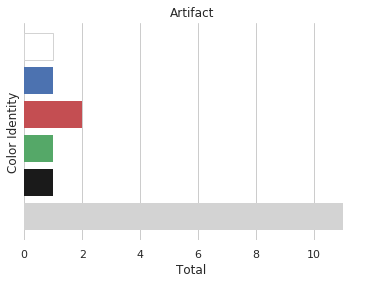

In [118]:
for group_id, (name, indices) in enumerate(group_result.indices.items()):
    group = pd_tab.iloc[indices]
    group.fillna(0)
    
#     print(group)

    f_group = group[group['Total'] > 0]

    labels = f_group['Color_Identity']
    totals = f_group['Total']

    sns.set(style="whitegrid")
    # sns.set()
    sns.set_palette("pastel")

    colors = {
        '': 'lightgray',
        'W': 'w',
        'U': 'b',
        'B': 'k',
        'R': 'r',
        'G': 'g'
    }

    edge_colors = {
        '': '',
        'W': 'lightgray',
        'U': '',
        'B': '',
        'R': '',
        'G': ''
    }

    prev = 0 
    for i in range(len(totals)):
        val = totals.iloc[i]
        label = labels.iloc[i]
        color = colors[label]
        ecolor = edge_colors[label]
        plt.barh(i, val, color=color, linewidth=1.0, alpha=1.0, edgecolor=ecolor)#, hatch="/")

    plt.title(model.labels[group_id])
    plt.xlabel('Total')  
    plt.ylabel('Color Identity')
#     plt.yticks(range(6), labels)
    plt.yticks([])
    sns.despine(left=True, bottom=True)

    plt.show()  
    
    break

### Bars with Gradients

In [176]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

def gradientbars(bars, color):
    grad = np.atleast_2d(np.linspace(0,1,256))
    rgb0 = matplotlib.colors.to_rgba('w')
    rgb1 = matplotlib.colors.to_rgba(color)
    cmap = LinearSegmentedColormap.from_list('tmp', (rgb0, rgb1))

    
    ax = bars[0].axes
    lim = ax.get_xlim() + ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x, x+w, y, y+h], cmap=cmap,aspect="auto", zorder=0)

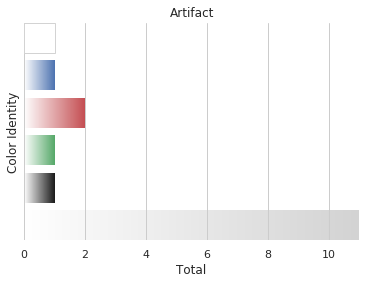

In [179]:
f_group = group[group['Total'] > 0]

labels = f_group['Color_Identity']
totals = f_group['Total']

sns.set_palette("pastel")


with sns.color_palette("pastel"):
    colors = {
        '': 'lightgray',
        'W': 'w',
        'U': 'b',
        'B': 'k',
        'R': 'r',
        'G': 'g'
    }

    edge_colors = {
        '': '',
        'W': 'lightgray',
        'U': '',
        'B': '',
        'R': '',
        'G': ''
    }

    fig, ax = plt.subplots()

    prev = 0 
    for i in range(len(totals)):
        val = totals.iloc[i]
        label = labels.iloc[i]
        color = colors[label]
        ecolor = edge_colors[label]
        bar = ax.barh(i, val, color=color, linewidth=1.0, alpha=1.0, edgecolor=ecolor)#, hatch="/")
        
        gradientbars(bar, color)

    ax.set_title(model.labels[group_id])
    ax.set_xlabel('Total')  
    ax.set_ylabel('Color Identity')
    #     plt.yticks(range(6), labels)
    ax.set_yticks([])
    ax.axis('auto')
    sns.despine(left=True, bottom=True)

    plt.show()  

### Bars with Gradient and Symbols

In [166]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [188]:
sns.set()

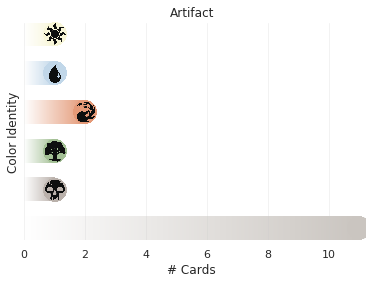

In [194]:
f_group = group[group['Total'] > 0]

labels = f_group['Color_Identity']
totals = f_group['Total']

sns.set(style="whitegrid")
# sns.set()
sns.set_palette("pastel")

colors = {
    '': '#cac5c0ff',
    'W': '#f8f6d8ff',
    'U': '#c1d7e9ff',
    'B': '#bab1abff',
    'R': '#e49977ff',
    'G': '#a3c095ff'
}

edge_colors = {
    '': '',
    'W': '',
    'U': '',
    'B': '',
    'R': '',
    'G': ''
}

images = {
    '': '../assets/Mana/C.png',
    'W': '../assets/Mana/W.png',
    'U': '../assets/Mana/U.png',
    'B': '../assets/Mana/B.png',
    'R': '../assets/Mana/R.png',
    'G': '../assets/Mana/G.png'
}

fig, ax = plt.subplots()

prev = 0 
for i in range(len(totals)):
    val = totals.iloc[i]
    label = labels.iloc[i]
    color = colors[label]
    ecolor = ''
    image = images[label]
    bar = plt.barh(i, val, color=color, height=0.60, linewidth=0.0, alpha=1.0, edgecolor=ecolor)#, hatch='/')
    
    ab = AnnotationBbox(OffsetImage(plt.imread(image), zoom=0.075), (val, i), frameon=False)
    ax.add_artist(ab)
    
    gradientbars(bar, color)

plt.title(model.labels[group_id])
plt.xlabel('# Cards')  
plt.ylabel('Color Identity')
plt.yticks([])
plt.grid(linewidth=1.0, alpha=0.25)
sns.despine(left=True, bottom=True)
plt.axis('auto')


plt.show()  

###  Cummulative Bar

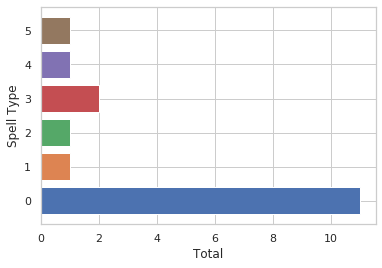

In [185]:
sns.set(style="whitegrid")

prev = 0 
for i in range(len(totals)):
    val = totals.iloc[i]
    label = labels.iloc[i]
    
    plt.barh(i, val)
#     prev = prev + val

plt.xlabel('Total')  
plt.ylabel('Spell Type')

plt.show()  